The test data doesn't have TOM columns. After examine predictions with masked TOM columns, I think it is better we refit the model, although for odor prediction the effect is not so significant.

Models:
- AdaBoostRegressor with DecisionTreeRegressor as the base estimator
- RandomForestRegressor
- SVR

In [3]:
random_state=190624

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
import itertools
import compose
%matplotlib inline


import sys
import os
sys.path.append(os.path.join(
    os.path.abspath(os.path.pardir), 'src'
))

import nzcompetition
from nzcompetition.preparation import make_prep_pipeline
from nzcompetition.plots import plot_train_pred, plot_pred_distribution

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import (
    Ridge, 
    Lasso, 
    ElasticNet, 
    ElasticNetCV, 
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    AdaBoostRegressor
)
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV
)
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from scipy.stats import (
    randint, 
    expon, 
    reciprocal, 
    uniform, 
    norm,
)


y_col = 'odor'
# for plotting
lim=[0, 3.5]

# Data

In [2]:
X_train, y, X_val = nzcompetition.get_raw_data(target=y_col)
X_train, y = nzcompetition.drop_dup(X_train, y)
X_train = nzcompetition.drop_tom(X_train)
X_val = nzcompetition.drop_tom(X_val)

In [6]:
X_test = nzcompetition.get_test_data()

The `Xdct` has been created by notebook 6.3 thus we can restore it directly.

In [3]:
%store -r

In [5]:
len(Xdct)

48

```python
# this takes very long...

Xdct = dict.fromkeys(itertools.product(
    # use_seq_mut_feature
    [True, False], 
    # use_seq_prot_feature
    [True, False], 
    # use_org_feature
    [True, False], 
    # max_na_ratio
    [1.0, 0.7, 0.3], 
    # PCA nestimator
    [None, 0.98], 
))

for seqmut, seqprot, org, naratio, pca_n_est in Xdct.keys():
    prep_pipe = make_prep_pipeline(seqmut, seqprot, org, naratio)
    X_train_prep = prep_pipe.fit_transform(X_train)
    X_val_prep = prep_pipe.transform(X_val)
    if pca_n_est:
        pca = PCA(pca_n_est)
        X_train_prep = pca.fit_transform(X_train_prep)
        X_val_prep = pca.transform(X_val_prep)
    Xdct[(seqmut, seqprot, org, naratio, pca_n_est)] = (X_train_prep, X_val_prep)

%store Xdct
```

In [7]:
Xdf = pd.DataFrame(Xdct.keys(), columns=[
    'use_seq_mut_feature', 
    'use_seq_prot_feature', 
    'use_org_feature', 
    'max_na_ratio', 
    'pca'
])

Xdf = Xdf.set_index([
    'use_seq_mut_feature', 
    'use_seq_prot_feature', 
    'use_org_feature', 
    'max_na_ratio', 
    'pca'])
for col in ['Adaboost_MSE', 'Randfor_MSE', 'SVR_MSE']:
    Xdf[col] = np.nan

Now we can use the `seqmut, seqprot, org, naratio, pca_n_est` as key to access the processed training and test data in `Xdct`. And we can store the performance of each model to `Xdf`. 

# AdaBoostRegressor

In [9]:
%%time

model_column = 'Adaboost_MSE'
best_ada_CV = None

for seqmut, seqprot, org, naratio, pca_n_est in Xdct.keys():
    X, _ = Xdct[(seqmut, seqprot, org, naratio, pca_n_est)]
    params = dict(
        base_estimator__max_depth=[4,5],
        base_estimator__min_samples_leaf=[8,10],
        base_estimator__max_features=['sqrt', 0.75, 'auto'],
        learning_rate=[0.676]
    )

    grid_search = GridSearchCV(
        AdaBoostRegressor(
            base_estimator=DecisionTreeRegressor(), 
            random_state=random_state,
            n_estimators=100, 
        ), 
        param_grid=params,
        scoring='neg_mean_squared_error', 
        n_jobs=16, 
        cv=5, 
        verbose=0, 
        iid=False, 
    )
    grid_search.fit(X, y)
    
    if best_ada_CV is None:
        best_ada_CV = grid_search
    elif best_ada_CV.best_score_ < grid_search.best_score_:
        best_ada_CV = grid_search
        
    Xdf.loc[(seqmut, seqprot, org, naratio, pca_n_est), model_column] = grid_search.best_score_ * -1.0

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3

CPU times: user 17.1 s, sys: 440 ms, total: 17.5 s
Wall time: 1min


/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 15))

ax.barh(range(Xdf.shape[0]), Xdf[model_column].sort_values())
ax.set_yticks(range(Xdf.shape[0]))
ax.set_yticklabels(Xdf[model_column].sort_values().index)

fig.show()

For AdaBoostRegressor, we'll use the `TTF07N` to denote the preparation pipeline.

Now let's fine tune the model.

In [13]:
X, Xval = Xdct[(True, True, False, 0.7, None)]

In [14]:
%%time
param_dist = dict(
    base_estimator__max_depth=randint(3, 6),
    base_estimator__min_samples_leaf=randint(3, 15),
    base_estimator__min_samples_split=randint(4, 15),
    learning_rate=uniform(0.5, 0.5)
)

rand_search = RandomizedSearchCV(
    AdaBoostRegressor(
        base_estimator=DecisionTreeRegressor(), 
        n_estimators=200, 
    ), 
    param_distributions=param_dist, 
    n_iter=5000, 
    scoring='neg_mean_squared_error', 
    n_jobs=15, 
    cv=5, 
    verbose=0, 
    iid=False, 
)

rand_search.fit(X, y)

CPU times: user 1min 55s, sys: 5.4 s, total: 2min 1s
Wall time: 12min 19s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                                    max_depth=None,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                                                                                    min_weight_fraction_

In [15]:
print(rand_search.best_params_, rand_search.best_score_)

{'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 6, 'learning_rate': 0.8659769179092902} -0.46347215611634895


In [16]:
print(best_ada_CV.best_params_, best_ada_CV.best_score_)

{'base_estimator__max_features': 'sqrt', 'base_estimator__max_depth': 5, 'base_estimator__min_samples_leaf': 10, 'learning_rate': 0.676} -0.45939963246166393


In [18]:
mean_squared_error(y, rand_search.predict(X))

0.07442500710362557

In [17]:
mean_squared_error(y, best_ada_CV.predict(X))

0.09131393132460963

Here we use the random searched CV's best model.

In [19]:
ada_reg = rand_search.best_estimator_

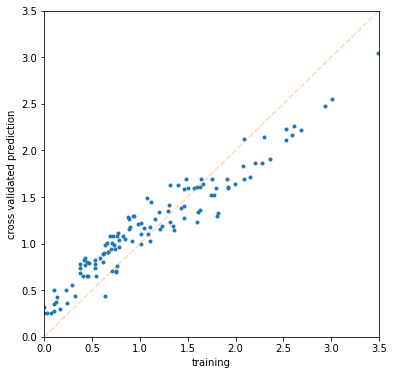

In [20]:
plot_train_pred(y, ada_reg.predict(X), lim)

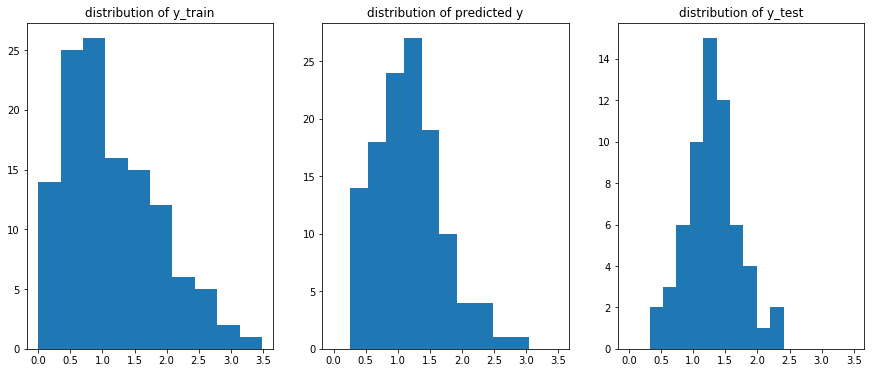

In [21]:
plot_pred_distribution(y, ada_reg.predict(X), ada_reg.predict(Xval))

There could be some overfitting. We need to regularize the model and check when it will have similar MSE in both training and validation.

Regularization on adaboost regressor: using less estimators, or regularize on base estimator.

Now we save the model and prediction.

In [22]:
prep_pipe = make_prep_pipeline(True, True, False, 0.7)
prep_pipe.fit(X_train)
X_test_prep = prep_pipe.transform(X_test)

pd.DataFrame(
    ada_reg.predict(X_test_prep), 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/submission/odor_TTF07N_adaboost.csv')

/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:242: RuntimeWarning: Mean of empty slice
  protdf['pI'] = np.nanmean(protdf[['pI_u', 'pI_p', 'pI_green']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:246: RuntimeWarning: Mean of empty slice
  protdf['molweight'] = np.nanmean(protdf[['molweight_u', 'molweight_p']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:226: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:242: RuntimeWarning: Mean of empty slice
  protdf['pI'] = np.nanmean(protdf[['pI_u', 'pI_p', 'pI_green']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:246: RuntimeWarning: Mean of empty slice
  protdf['molweight'] = np.nanmean(p

In [23]:
joblib.dump(ada_reg, '../models/submission/odor_TTF07N_adaboost.pkl')

['../models/submission/odor_TTF07N_adaboost.pkl']

This prediction got an MSE `0.3232` in test set.

# RandomForestRegressor

In [24]:
model_column = 'Randfor_MSE'
best_randfor_CV = None

for seqmut, seqprot, org, naratio, pca_n_est in Xdct.keys():
    X, _ = Xdct[(seqmut, seqprot, org, naratio, pca_n_est)]
    param = dict(
        max_depth=[4, 5], 
        max_features=['auto', 'sqrt', 0.7],
        min_samples_leaf=[5,7]
    )

    grid_search = GridSearchCV(
        RandomForestRegressor(n_estimators=100), 
        param_grid=param,
        scoring='neg_mean_squared_error', 
        n_jobs=16, 
        cv=5, 
        verbose=0, 
        iid=False, 
    )
    grid_search.fit(X, y)

    if best_randfor_CV is None:
        best_randfor_CV = grid_search
    elif best_randfor_CV.best_score_ < grid_search.best_score_:
        best_randfor_CV = grid_search
        
    Xdf.loc[(seqmut, seqprot, org, naratio, pca_n_est), model_column] = grid_search.best_score_ * -1.0

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-

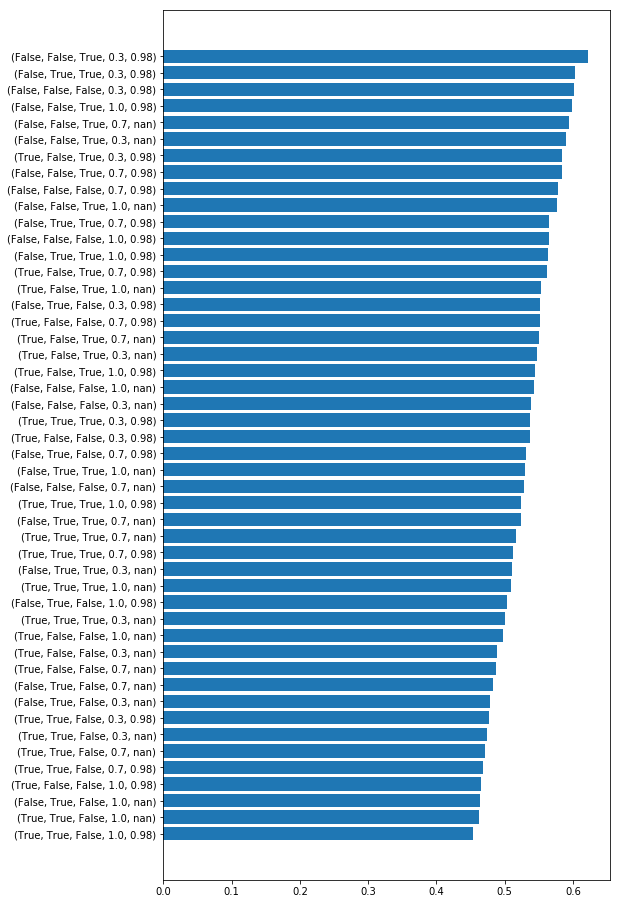

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))

ax.barh(range(Xdf.shape[0]), Xdf[model_column].sort_values())
ax.set_yticks(range(Xdf.shape[0]))
ax.set_yticklabels(Xdf[model_column].sort_values().index)

fig.show()

Now we know the best preparation code for RandomForestRegressor is `TTF10098`.

In [26]:
best_randfor_CV.best_params_

{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 7}

In [28]:
X, Xval = Xdct[(True, True, False, 1.0, 0.98)]

In [29]:
mean_squared_error(y, best_randfor_CV.predict(X))

0.1449577028134091

Try using more estimators.

In [38]:
randfor_reg = best_randfor_CV.best_estimator_
randfor_reg.set_params(n_estimators=300)
randfor_reg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=7, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [39]:
mean_squared_error(y, randfor_reg.predict(X))

0.1441719800684485

Basically the same.

In [40]:
plot_train_pred(y, randfor_reg.predict(X), lim)

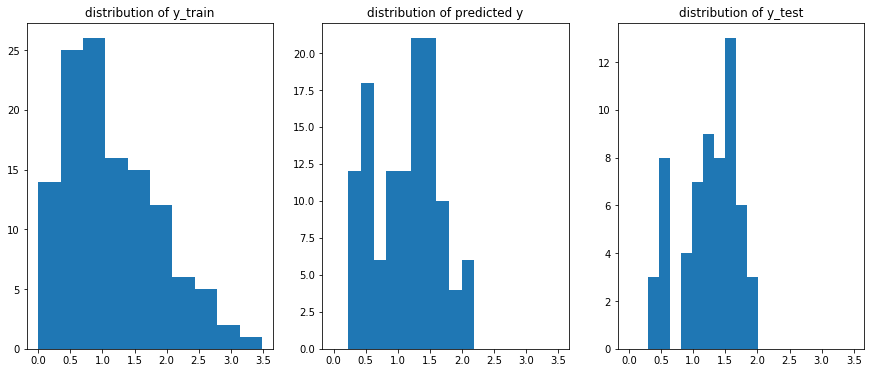

In [41]:
plot_pred_distribution(y, randfor_reg.predict(X), randfor_reg.predict(Xval))

In [42]:
mean_squared_error(y, randfor_reg.predict(X))

0.1441719800684485

In [43]:
prep_pipe = Pipeline([
    ('prep', make_prep_pipeline(True, True, False, 1.0)), 
    ('pca', PCA(0.98))
])
prep_pipe.fit(X_train)
X_test_prep = prep_pipe.transform(X_test)

pd.DataFrame(
    randfor_reg.predict(X_test_prep), 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/submission/odor_TTF10098_randfor.csv')

/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:242: RuntimeWarning: Mean of empty slice
  protdf['pI'] = np.nanmean(protdf[['pI_u', 'pI_p', 'pI_green']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:246: RuntimeWarning: Mean of empty slice
  protdf['molweight'] = np.nanmean(protdf[['molweight_u', 'molweight_p']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:226: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:242: RuntimeWarning: Mean of empty slice
  protdf['pI'] = np.nanmean(protdf[['pI_u', 'pI_p', 'pI_green']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:246: RuntimeWarning: Mean of empty slice
  protdf['molweight'] = np.nanmean(p

In [44]:
joblib.dump(randfor_reg, '../models/submission/odor_TTF10098_randfor.pkl')

['../models/submission/odor_TTF10098_randfor.pkl']

This model got a MSE `0.2606` in test set.

# SVR

In [46]:
model_column = 'SVR_MSE'
best_svr_CV = None

for seqmut, seqprot, org, naratio, pca_n_est in Xdct.keys():
    X, _ = Xdct[(seqmut, seqprot, org, naratio, pca_n_est)]
    param = dict(
        kernel=['rbf', 'linear', 'sigmoid'], 
        gamma=['auto', 0.01, 0.03, 0.1, 0.3, 1, 3], 
        C=[0.01, 0.03, 0.1, 1, 3, 10], 
        epsilon=[0.01, 0.03, 0.1, 0.3, 0.5]
    )

    grid_search = GridSearchCV(
        SVR(), 
        param_grid=param,
        scoring='neg_mean_squared_error', 
        n_jobs=16, 
        cv=5, 
        verbose=0, 
        iid=False, 
    )
    grid_search.fit(X, y)

    if best_svr_CV is None:
        best_svr_CV = grid_search
    elif best_svr_CV.best_score_ < grid_search.best_score_:
        best_svr_CV = grid_search
        
    Xdf.loc[(seqmut, seqprot, org, naratio, pca_n_est), model_column] = grid_search.best_score_ * -1.0

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-

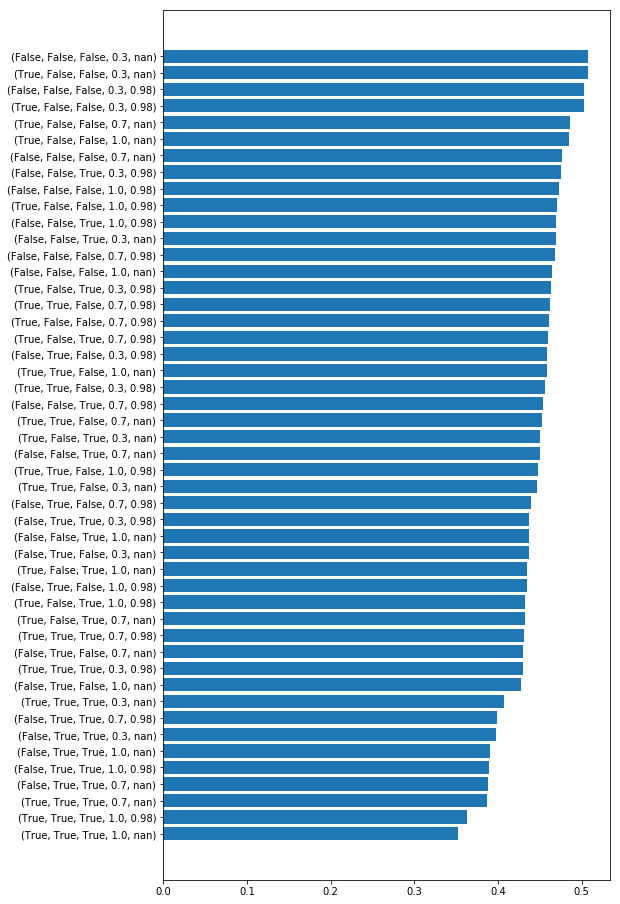

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))

ax.barh(range(Xdf.shape[0]), Xdf[model_column].sort_values())
ax.set_yticks(range(Xdf.shape[0]))
ax.set_yticklabels(Xdf[model_column].sort_values().index)

fig.show()

Now we know the best preparation code for SVR is `TTT10N`.

In [48]:
print(best_svr_CV.best_params_, best_svr_CV.best_score_)

{'kernel': 'sigmoid', 'gamma': 0.1, 'C': 0.1, 'epsilon': 0.01} -0.3520625844104538


Now we can fine tune this model.

In [49]:
X, Xval = Xdct[(True, True, True, 1.0, None)]

In [50]:
mean_squared_error(y, best_svr_CV.predict(X))

0.6883523939620649

In [51]:
%%time
param_dist = dict(
    C=reciprocal(0.08, 10),
    gamma=expon(scale=1.0), 
    kernel=['sigmoid', 'rbf']
)

rand_search = RandomizedSearchCV(
    SVR(), 
    param_distributions=param_dist, 
    n_iter=5000, 
    scoring='neg_mean_squared_error', 
    n_jobs=15, 
    cv=5, 
    verbose=0, 
    iid=False, 
)

rand_search.fit(X, y)

CPU times: user 17.2 s, sys: 571 ms, total: 17.8 s
Wall time: 23.6 s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid=False, n_iter=5000, n_jobs=15,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc5b0b53908>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc6160ea470>,
                                        'kernel': ['sigmoid', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=0)

In [52]:
print(rand_search.best_params_, rand_search.best_score_)
print(best_svr_CV.best_params_, best_svr_CV.best_score_)

{'kernel': 'sigmoid', 'C': 0.18507111873619397, 'gamma': 0.051591091965528815} -0.39661086270290263
{'kernel': 'sigmoid', 'gamma': 0.1, 'C': 0.1, 'epsilon': 0.01} -0.3520625844104538


Since the rand search didn't yield better precision, we still use the grid searched model.

In [53]:
svr = best_svr_CV.best_estimator_

In [54]:
plot_train_pred(y, svr.predict(X), lim)

Thus SVR is not a good model for this task.